# Immgen ATAC-Seq


In [130]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
import re
import tempfile
import pyranges as pr
from pyranges import PyRanges


In [94]:
PATH = os.path.expanduser('~/data/2024_Immgen')
! mkdir -p {PATH}/pics

def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))


def file_to_srr(file):
    return re.sub('_.*', '', os.path.basename(file))

In [161]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

# Load peaks

In [96]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [97]:
def atac_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def atac_load_peaks_path(path):
    df_macs2 = atac_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = atac_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2', len(df_macs2_broad))

    df_sicer = atac_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = atac_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span]).reset_index(drop=True)

In [102]:
dfa = atac_load_peaks_path(PATH)
dfa['name'] = [file_to_name(f) for f in dfa['file']]
dfa['srr'] = [file_to_srr(f) for f in dfa['file']]
dfa.sort_values(by='name', inplace=True)
print(list(sorted(dfa['name'].unique())))
dfa.sample(3)

  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 185


  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 185


  0%|          | 0/185 [00:00<?, ?it/s]

SICER 185


  0%|          | 0/740 [00:00<?, ?it/s]

SPAN 185
['Blood_Monocyte', 'Bone_marrow_B_Cell', 'Bone_marrow_NK_Cell', 'Bone_marrow_Neutrophil', 'Bone_marrow_Stem_Cell', 'Colon_CD4_Treg_Cell', 'Lung_Macrophage', 'Lymph_nodes_gdT_Cell', 'Peritoneal_cavity_B_Cell', 'Peritoneal_cavity_Macrophage', 'Peritoneal_cavity_Neutrophil', 'Skin_draining_lymph_node_Stromal_Cell', 'Small_Intestine_CD8_T_Cell', 'Small_intestine_Dendritic_Cell', 'Small_intestine_Innate_Lymphocytes', 'Small_intestine_lamina_propria_Macrophage', 'Spleen_Activated_T_Cell', 'Spleen_B_Cell', 'Spleen_CD4_Naive_T_Cell', 'Spleen_CD4_Treg_Cell', 'Spleen_CD8_Naive_T_Cell', 'Spleen_CD8_T_Cell', 'Spleen_Dendritic_Cell', 'Spleen_Macrophage', 'Spleen_NKT_Cell', 'Spleen_NK_Cell', 'Spleen_Neutrophil', 'Spleen_gdT_Cell', 'Thymus_CD4_SP_Thymocytes', 'Thymus_CD8_SP_Thymocytes', 'Thymus_DP_Thymocytes', 'Thymus_Double_Negative_Thymocytes', 'Thymus_Immature_Single_Positive_Thymocytes', 'Thymus_Thymic_epithelial_Cell', 'Thymus_gdT_Cell', 'brain_Microglia']


file  peaks         tool  \
175  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  51605        MACS2   
346  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  15587  MACS2 broad   
200  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  19890  MACS2 broad   

                      name         srr  
175  Spleen_Dendritic_Cell  SRR5799502  
346        brain_Microglia  SRR5799540  
200          Spleen_B_Cell  SRR5799459

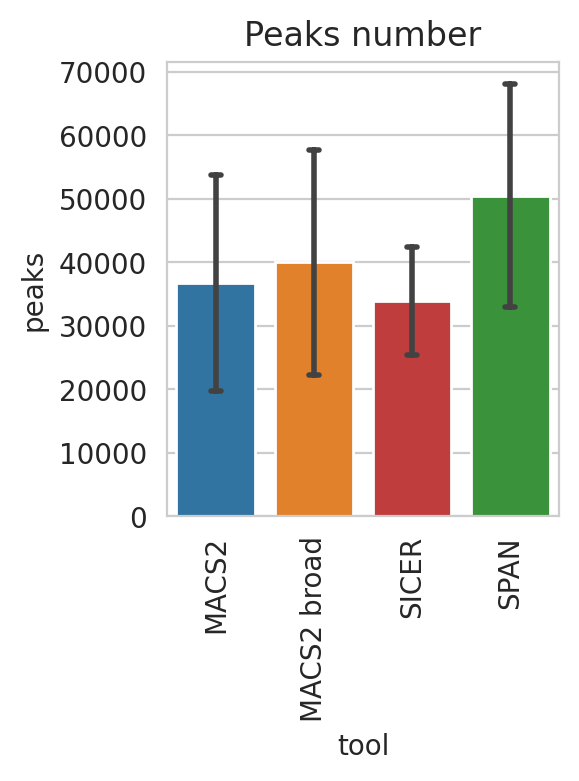

In [104]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=dfa, x='tool', y='peaks',
            order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            hue='tool',
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.1,
            err_kws={'linewidth': 2},
            legend=False,
            ax=ax)
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

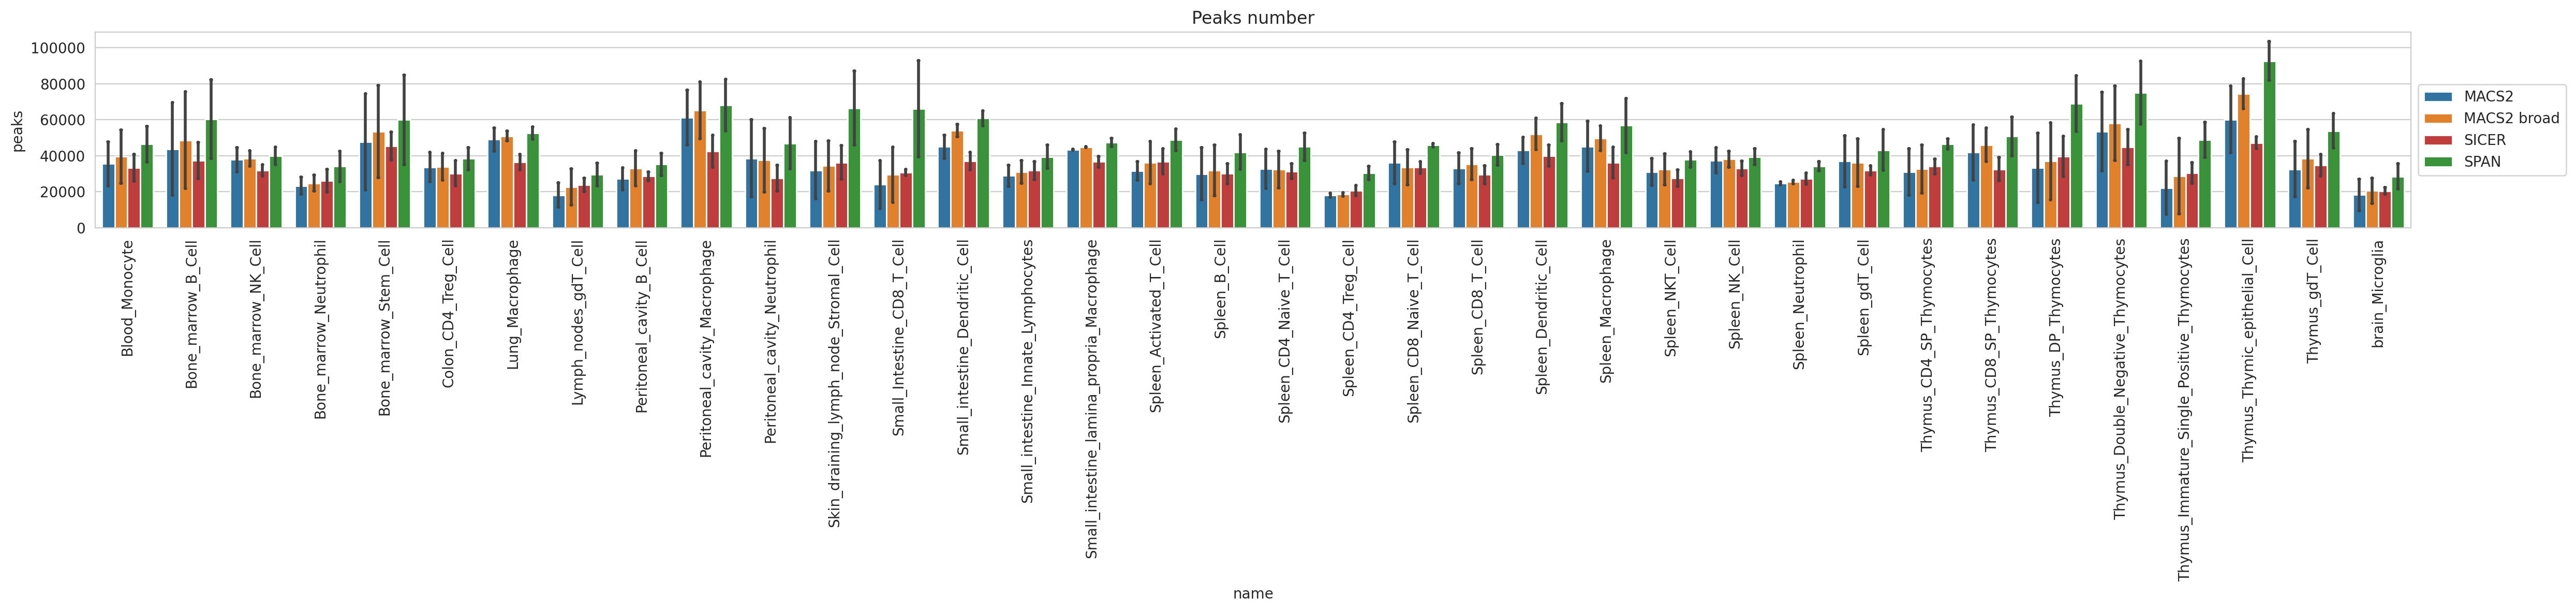

In [105]:
plt.figure(figsize=(25, 6))
g_result = sns.barplot(data=dfa, x='name', y='peaks', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                       palette=TOOLS_PALETTE,
                       errorbar='sd', capsize=.05,
                       err_kws={'linewidth': 2}
                       )
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [87]:
dfa[dfa['tool'] == 'MACS2 broad'].groupby(['name'])['file'].count().astype(int)

name
Blood_Monocyte                                 6
Bone_marrow_B_Cell                            12
Bone_marrow_NK_Cell                            6
Bone_marrow_Neutrophil                         2
Bone_marrow_Stem_Cell                          5
Colon_CD4_Treg_Cell                            2
Lung_Macrophage                                4
Lymph_nodes_gdT_Cell                           6
Peritoneal_cavity_B_Cell                       2
Peritoneal_cavity_Macrophage                  10
Peritoneal_cavity_Neutrophil                   3
Skin_draining_lymph_node_Stromal_Cell          8
Small_Intestine_CD8_T_Cell                     2
Small_intestine_Dendritic_Cell                 4
Small_intestine_Innate_Lymphocytes             8
Small_intestine_lamina_propria_Macrophage      2
Spleen_Activated_T_Cell                        2
Spleen_B_Cell                                 25
Spleen_CD4_Naive_T_Cell                        4
Spleen_CD4_Treg_Cell                           2
Spleen_CD8_Naiv

In [88]:
ts = []
for srr, name, tool, file in tqdm(zip(dfa['srr'], dfa['name'], dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    # Some tracks may have open chromatin clusters, which significantly affects average, 
    # so pick only lengths limited to 80%
    t.sort_values(by=['length'], inplace=True)
    t = t.iloc[0:int(len(t) * 0.8)].copy()
    t = t.sample(min(len(t), 10_000)).copy()
    t['srr'] = srr
    t['name'] = name
    t['tool'] = tool
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts
df_lens.sample(10)

0it [00:00, ?it/s]

length         srr                                name         tool
2804956     171  SRR5799526      Small_intestine_Dendritic_Cell        MACS2
2944680     195  SRR5799484  Small_intestine_Innate_Lymphocytes         SPAN
369179       73  SRR5799447                  Bone_marrow_B_Cell        MACS2
4170728      73  SRR5799515                       Spleen_B_Cell  MACS2 broad
7245382     152  SRR5799422                     Thymus_gdT_Cell        MACS2
3384385     295  SRR5799514                       Spleen_B_Cell         SPAN
6661563     695  SRR5799388   Thymus_Double_Negative_Thymocytes         SPAN
117659       93  SRR5799542                      Blood_Monocyte        MACS2
20005        82  SRR5799491                      Blood_Monocyte  MACS2 broad
6564944      95  SRR5799390   Thymus_Double_Negative_Thymocytes         SPAN

<Figure size 2500x600 with 0 Axes>

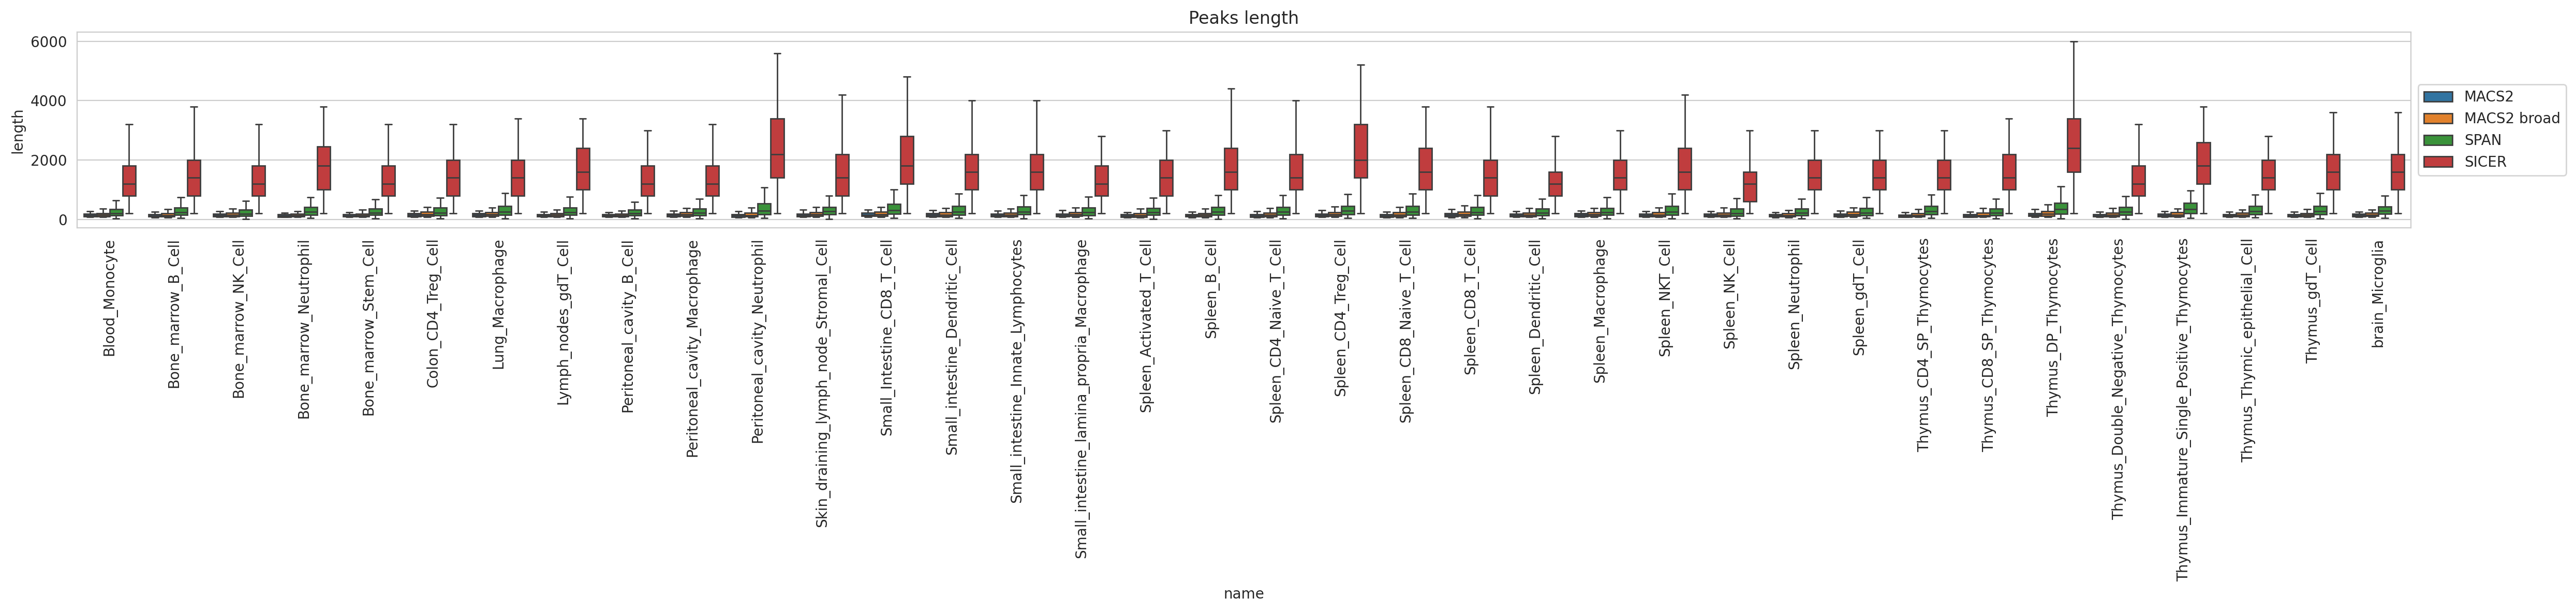

In [91]:
plt.figure(figsize=(25, 6))
g_result = sns.boxplot(data=df_lens, x='name', y='length', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       palette=TOOLS_PALETTE,
                       showfliers=False)
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

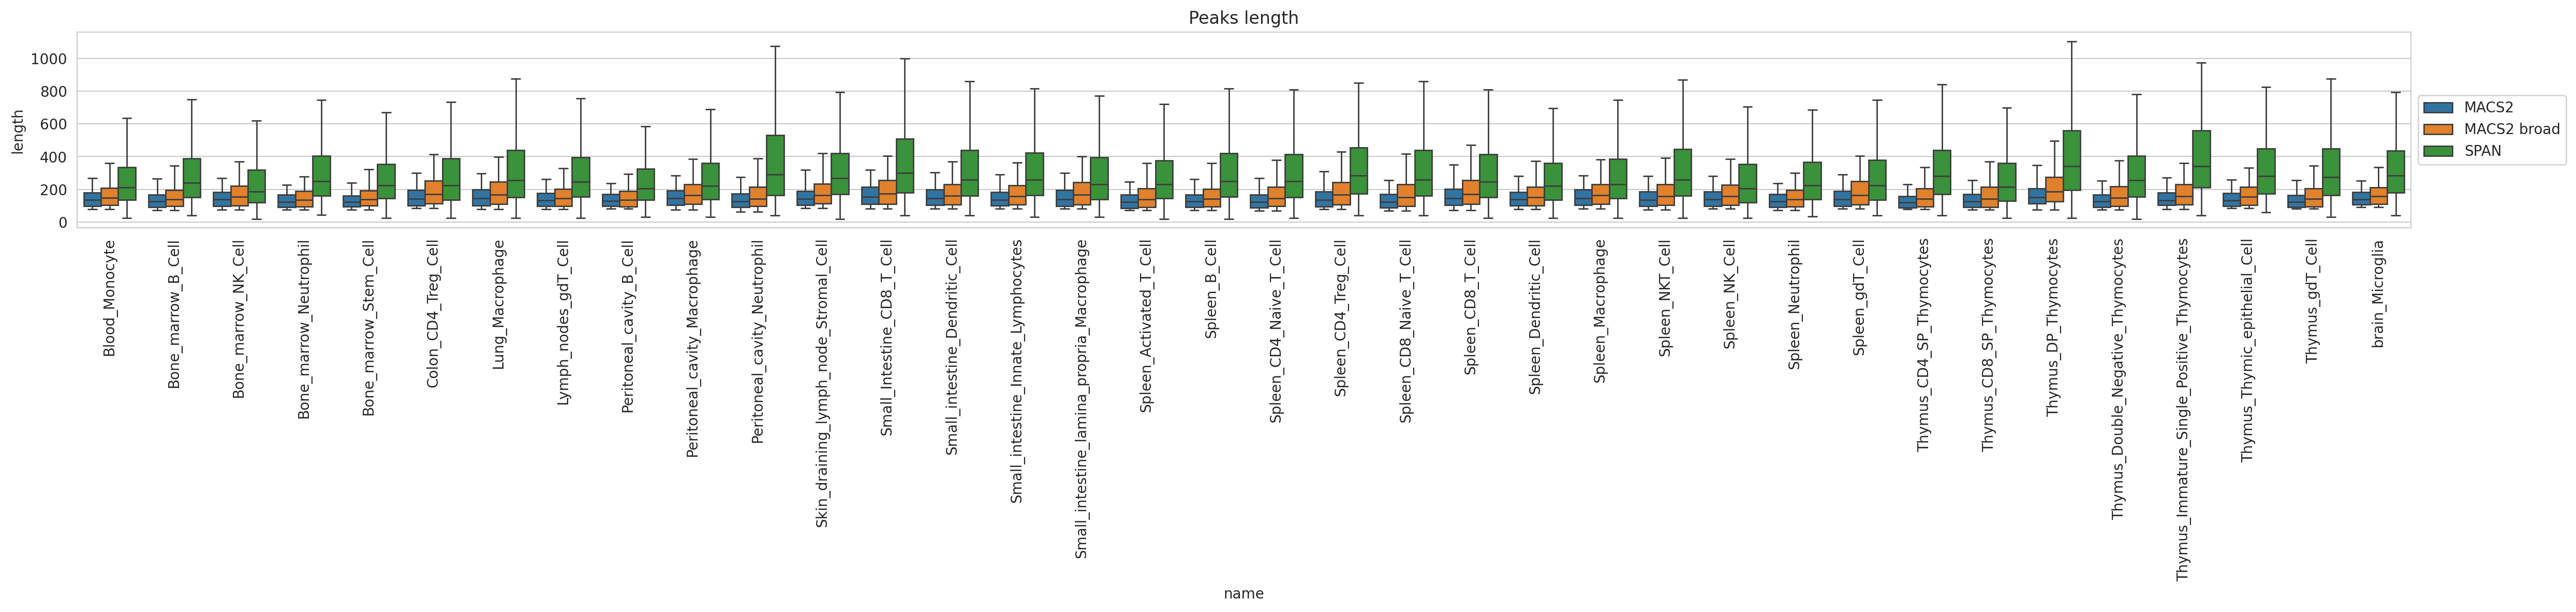

In [92]:
plt.figure(figsize=(25, 6))
g_result = sns.boxplot(data=df_lens[df_lens['tool'] != 'SICER'], x='name', y='length', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
                       palette=TOOLS_PALETTE,
                       showfliers=False)
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

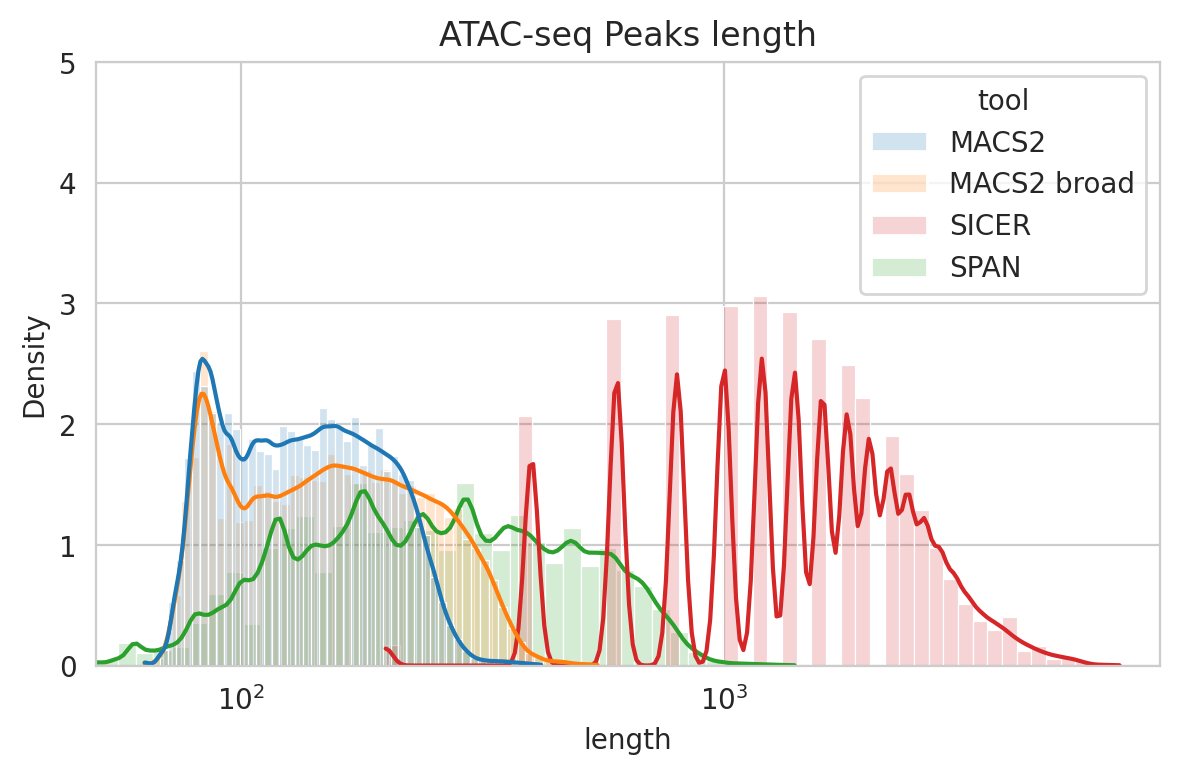

In [45]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.histplot(data=df_lens, x='length', hue='tool', ax=ax,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(50, 8e3)
ax.title.set_text('ATAC-seq Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Overlaps

In [46]:
! mkdir {PATH}/overlaps
import pyranges as pr


def compute_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file1', 'file2',
                                      'peaks1', 'peaks2', 'overlap12', 'overlap21',
                                      'peaks1_len', 'peaks2_len', 'overlap_len'], dtype=object)
    for (name, tool), dft in tqdm(list(df.groupby(['name', 'tool']))):
        print('Processing', name, tool, len(dft))
        if len(dft) < 2:
            continue
        files = list(dft['file'])
        ranges = [None] * len(files)
        peaks = [-1] * len(files)
        peaks_lens = [-1] * len(files)
        # print('Load')
        for i, file in enumerate(files):
            peaks[i] = lines(file)
            if peaks[i] == 0:
                peaks_lens[i] = 0
                continue
            ranges[i] = pr.read_bed(sorted_file(file))
            peaks_lens[i] = ranges[i].lengths().sum()
        for i, j in product(range(len(ranges)), range(len(ranges))):
            if i >= j:
                continue
            file1, file2 = files[i], files[j]
            ranges1, ranges2 = ranges[i], ranges[j]
            peaks1, peaks2 = peaks[i], peaks[j]
            peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
            if peaks1 <= 0 or peaks2 <= 0:
                dfoverlap.loc[len(dfoverlap)] = (name, tool, file1, file2,
                                                 peaks1, peaks2, 0, 0,
                                                 peaks1_len, peaks2_len, 0)
                continue
            overlap1 = len(ranges1.overlap(ranges2))
            overlap2 = len(ranges2.overlap(ranges1))
            overlap_len = ranges1.intersect(ranges2).lengths().sum()
            dfoverlap.loc[len(dfoverlap)] = (name, tool, file1, file2,
                                             peaks1, peaks2, overlap1, overlap2,
                                             peaks1_len, peaks2_len, overlap_len)
    return dfoverlap

mkdir: cannot create directory ‘/home/jetbrains/data/2024_Immgen/overlaps’: File exists


In [47]:
df_overlap = compute_overlaps(dfa)

  0%|          | 0/144 [00:00<?, ?it/s]

Processing Blood_Monocyte MACS2 6
Processing Blood_Monocyte MACS2 broad 6
Processing Blood_Monocyte SICER 6
Processing Blood_Monocyte SPAN 6
Processing Bone_marrow_B_Cell MACS2 12
Processing Bone_marrow_B_Cell MACS2 broad 12
Processing Bone_marrow_B_Cell SICER 12
Processing Bone_marrow_B_Cell SPAN 12
Processing Bone_marrow_NK_Cell MACS2 6
Processing Bone_marrow_NK_Cell MACS2 broad 6
Processing Bone_marrow_NK_Cell SICER 6
Processing Bone_marrow_NK_Cell SPAN 6
Processing Bone_marrow_Neutrophil MACS2 2
Processing Bone_marrow_Neutrophil MACS2 broad 2
Processing Bone_marrow_Neutrophil SICER 2
Processing Bone_marrow_Neutrophil SPAN 2
Processing Bone_marrow_Stem_Cell MACS2 5
Processing Bone_marrow_Stem_Cell MACS2 broad 5
Processing Bone_marrow_Stem_Cell SICER 5
Processing Bone_marrow_Stem_Cell SPAN 5
Processing Colon_CD4_Treg_Cell MACS2 2
Processing Colon_CD4_Treg_Cell MACS2 broad 2
Processing Colon_CD4_Treg_Cell SICER 2
Processing Colon_CD4_Treg_Cell SPAN 2
Processing Lung_Macrophage MACS2 4

In [48]:
df_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(df_overlap['peaks1_len'], df_overlap['peaks2_len'], df_overlap['overlap_len'])
]
df_overlap.sort_values(by='name', inplace=True)

Jaccard


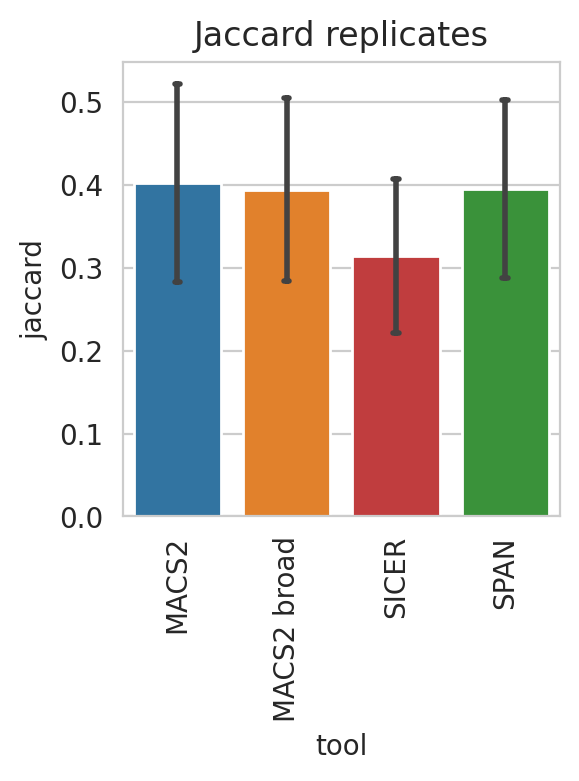

In [49]:
print('Jaccard')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=df_overlap,
                       x='tool', y='jaccard',
                       order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                       hue='tool', legend=False,
                       palette=TOOLS_PALETTE,
                       errorbar='sd', capsize=.05,
                       err_kws={'linewidth': 2}
                       )
plt.xticks(rotation=90)
plt.title('Jaccard replicates')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

Jaccard


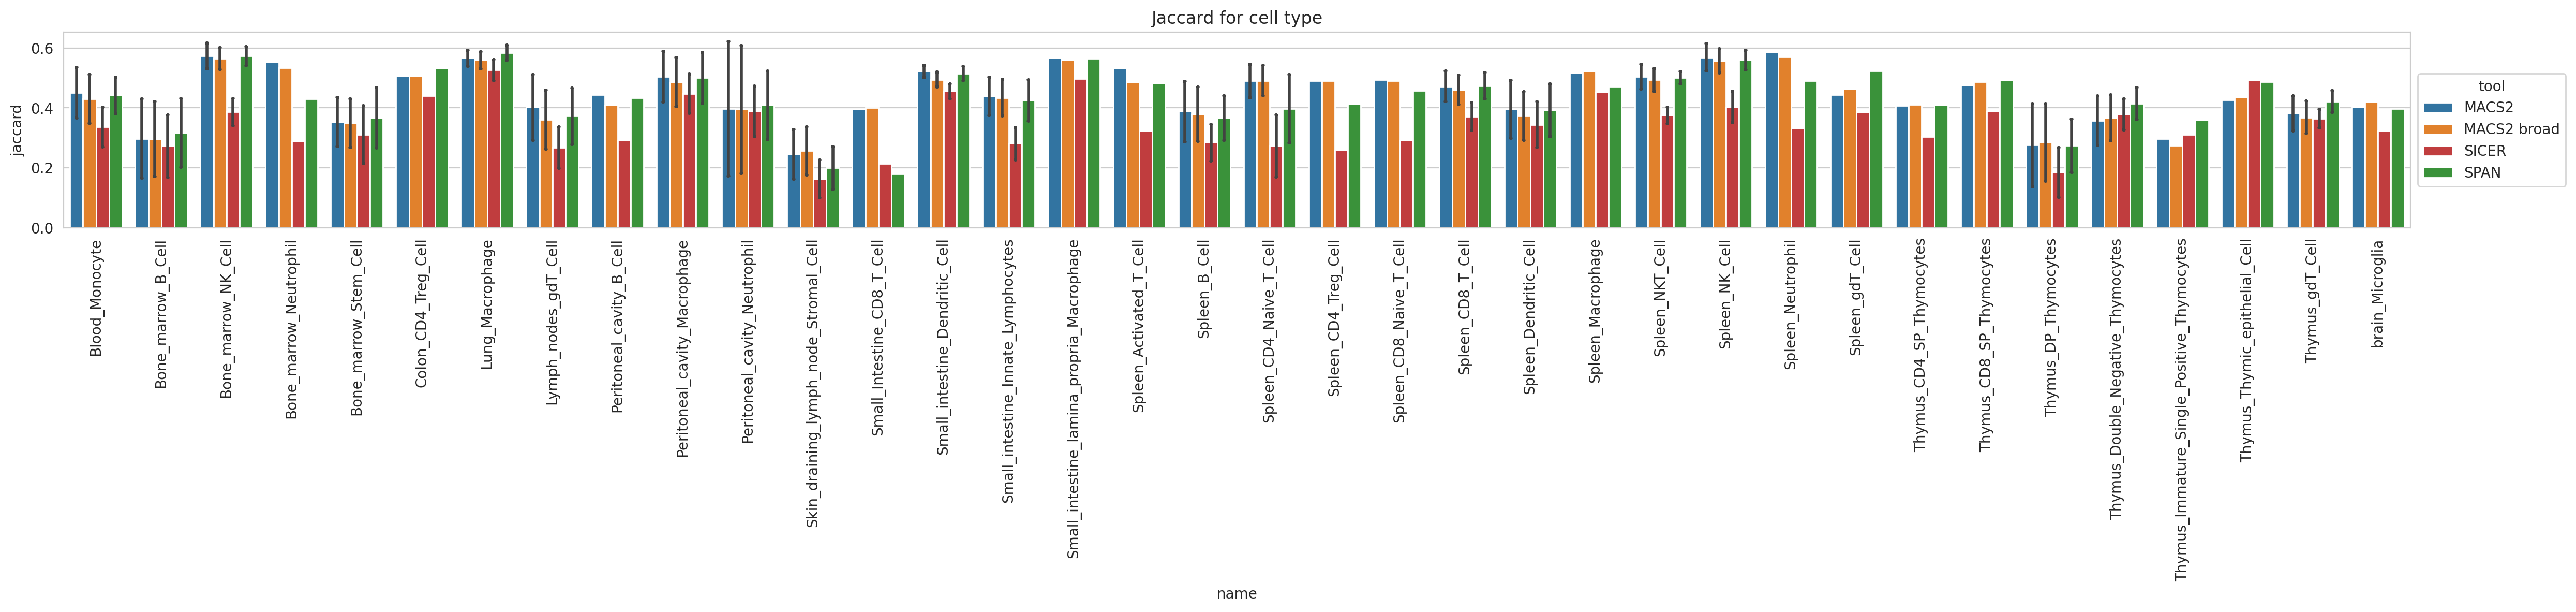

In [50]:
print('Jaccard')

plt.figure(figsize=(25, 6))
ax = plt.axes()
sns.barplot(data=df_overlap,
            x='name', y='jaccard',
            hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05,
            err_kws={'linewidth': 2},
            ax=ax)
plt.xticks(rotation=90)
plt.title('Jaccard for cell type')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference

In [99]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'srr', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()

for srr in tqdm(dfa['srr'].unique()):
    print(srr)
    t = dfa[(dfa['tool'] == 'SPAN') & (dfa['srr'] == srr)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    cell_name = t['name'].values[0]
    # Processing single tools information
    for tool in dfa['tool'].unique():
        if tool == 'SPAN':
            continue
        t = dfa[(dfa['tool'] == tool) & (dfa['srr'] == srr)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !echo '' > {tf}
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (cell_name, srr, name, peaks)
diff_bench_df

  0%|          | 0/185 [00:00<?, ?it/s]

SRR5799494
SRR5799493
SRR5799491
SRR5799542
SRR5799492
SRR5799541
SRR5799447
SRR5799454
SRR5799533
SRR5799449
SRR5799448
SRR5799455
SRR5799471
SRR5799451
SRR5799452
SRR5799470
SRR5799453
SRR5799450
SRR5799421
SRR5799419
SRR5799420
SRR5799416
SRR5799418
SRR5799417
SRR5799405
SRR5799406
SRR5799530
SRR5799537
SRR5799528
SRR5799539
SRR5799538
SRR5799404
SRR5799403
SRR5799518
SRR5799520
SRR5799521
SRR5799519
SRR5799431
SRR5799430
SRR5799432
SRR5799433
SRR5799428
SRR5799429
SRR5799461
SRR5799517
SRR5799536
SRR5799532
SRR5799531
SRR5799498
SRR5799529
SRR5799544
SRR5799497
SRR5799496
SRR5799543
SRR5799495
SRR5799549
SRR5799548
SRR5799409
SRR5799508
SRR5799510
SRR5799552
SRR5799506
SRR5799511
SRR5799509
SRR5799507
SRR5799550
SRR5799445
SRR5799444
SRR5799526
SRR5799527
SRR5799525
SRR5799524
SRR5799483
SRR5799487
SRR5799486
SRR5799488
SRR5799484
SRR5799485
SRR5799489
SRR5799490
SRR5799523
SRR5799522
SRR5799402
SRR5799401
SRR5799459
SRR5799458
SRR5799474
SRR5799514
SRR5799464
SRR5799516
SRR5799463

cell         srr                name  peaks
0      Blood_Monocyte  SRR5799494        SPAN - SICER   9871
1      Blood_Monocyte  SRR5799494        SICER - SPAN   1300
2      Blood_Monocyte  SRR5799494  SPAN - MACS2 broad  12802
3      Blood_Monocyte  SRR5799494  MACS2 broad - SPAN    171
4      Blood_Monocyte  SRR5799494        SPAN - MACS2  14585
...               ...         ...                 ...    ...
1105  brain_Microglia  SRR5799505        SICER - SPAN    644
1106  brain_Microglia  SRR5799505  SPAN - MACS2 broad  10534
1107  brain_Microglia  SRR5799505  MACS2 broad - SPAN    122
1108  brain_Microglia  SRR5799505        SPAN - MACS2  12483
1109  brain_Microglia  SRR5799505        MACS2 - SPAN     92

[1110 rows x 4 columns]

Diff


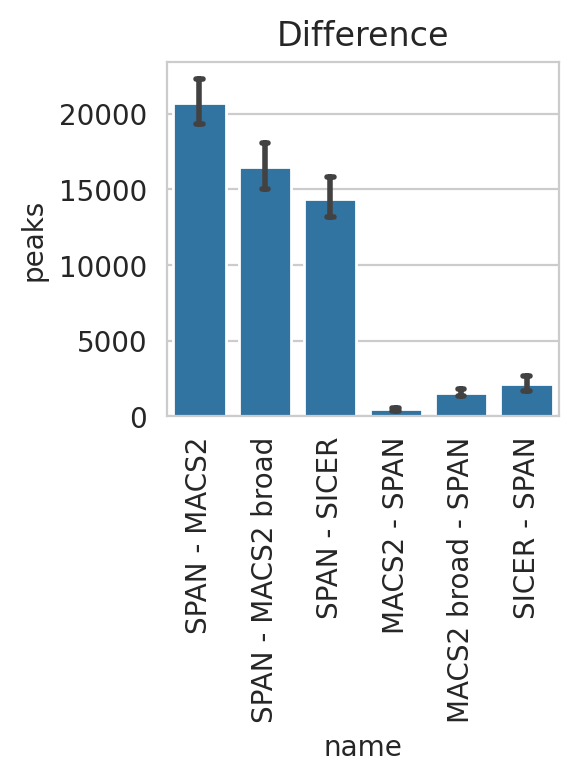

In [106]:
print('Diff')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=diff_bench_df,
                       x='name', y='peaks',
                       order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
                       # order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
                       capsize=.1, err_kws={'linewidth': 2},
                       )
plt.xticks(rotation=90)
plt.title('Difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


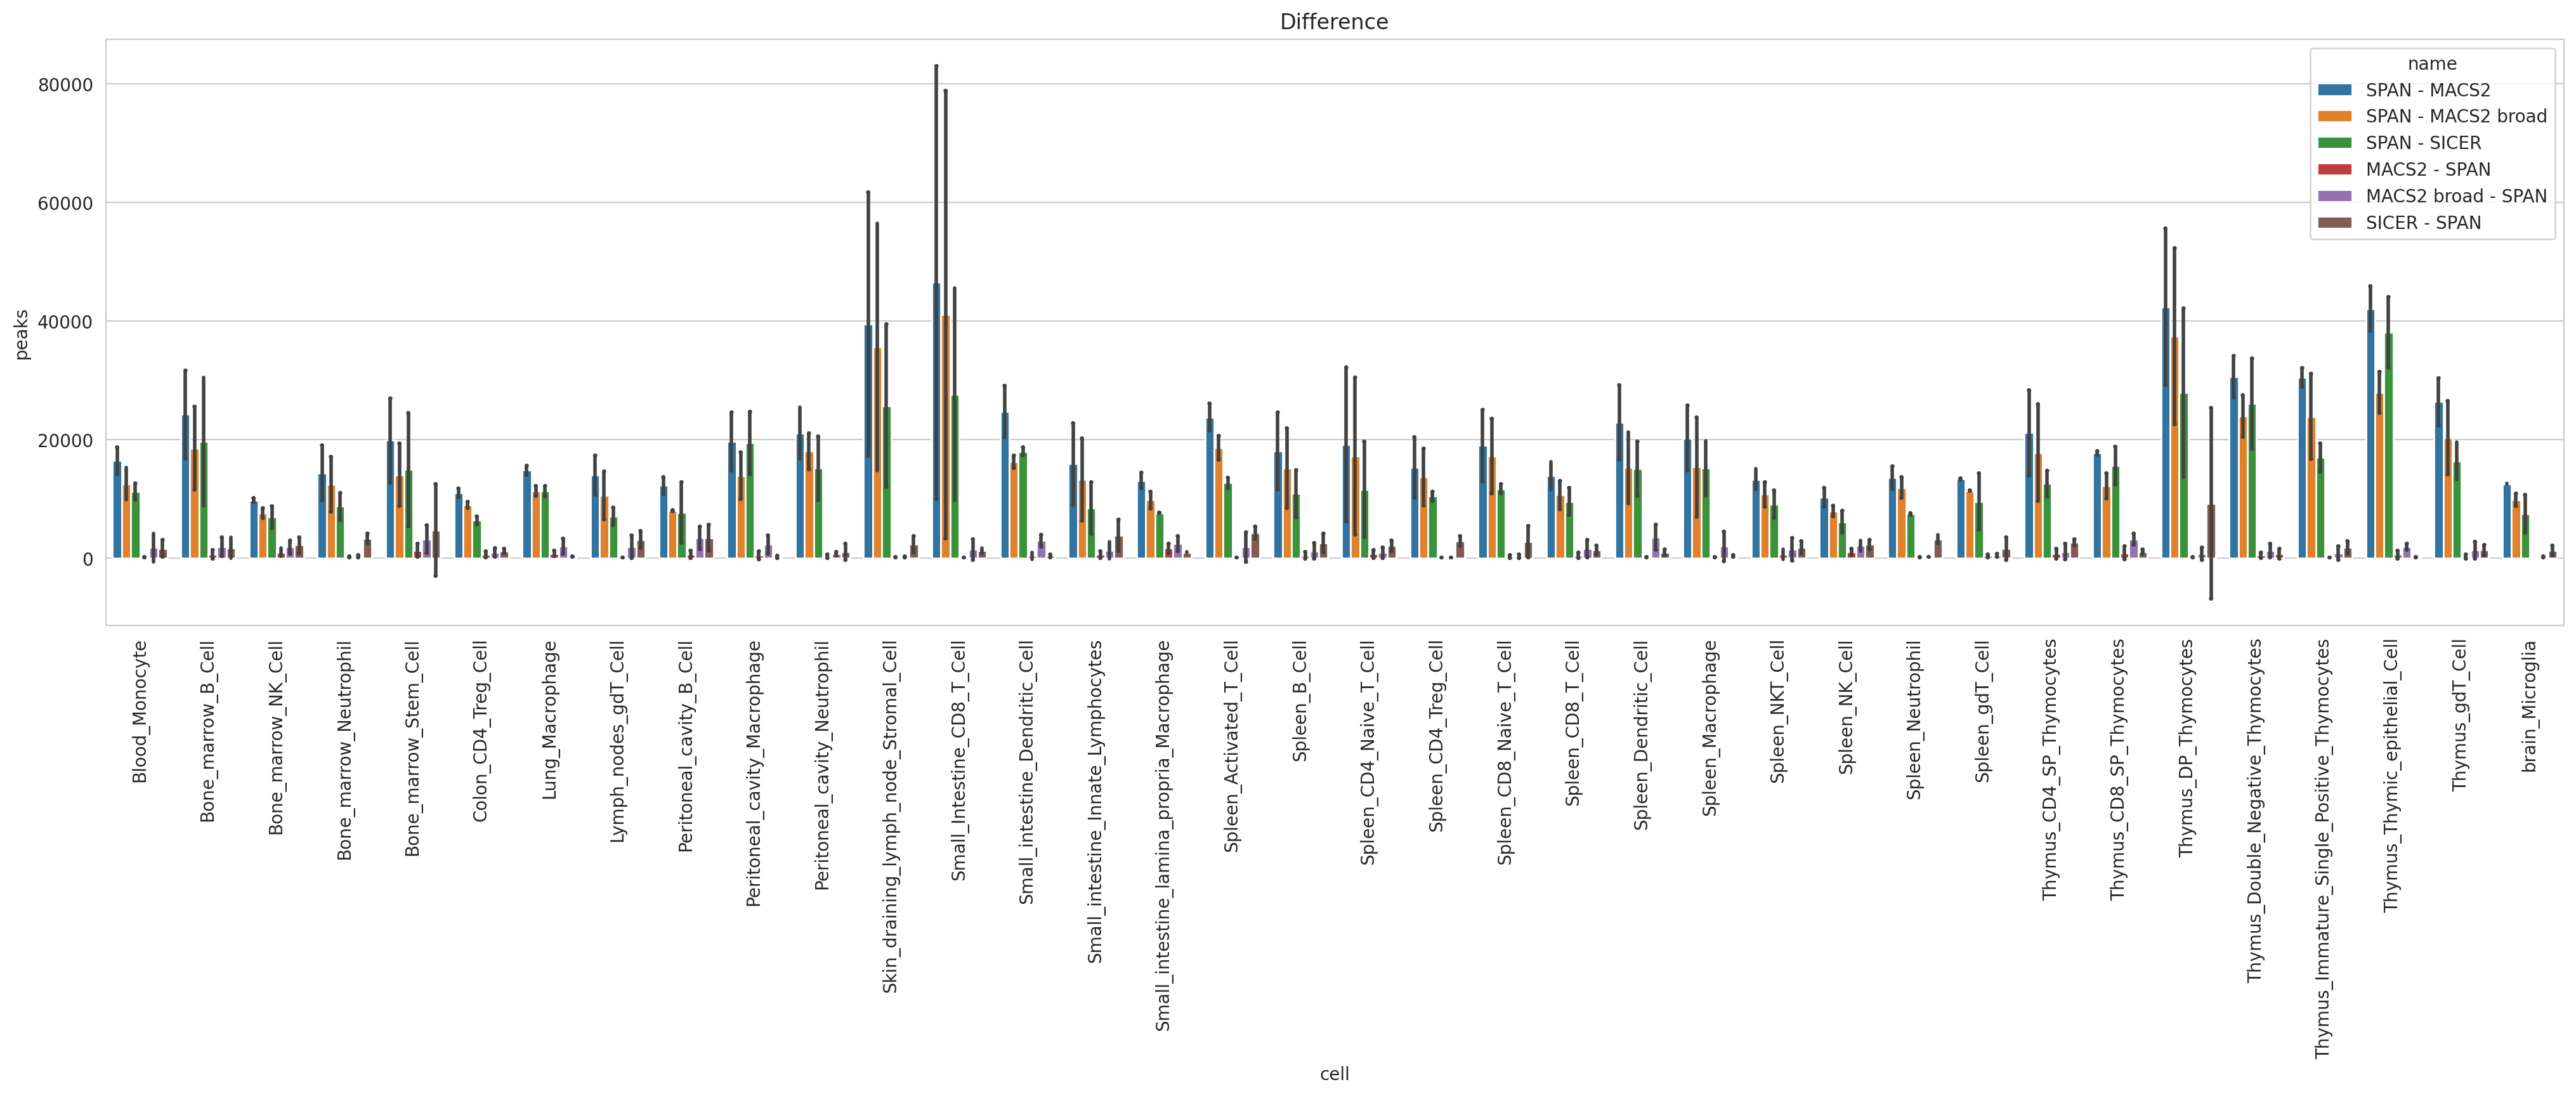

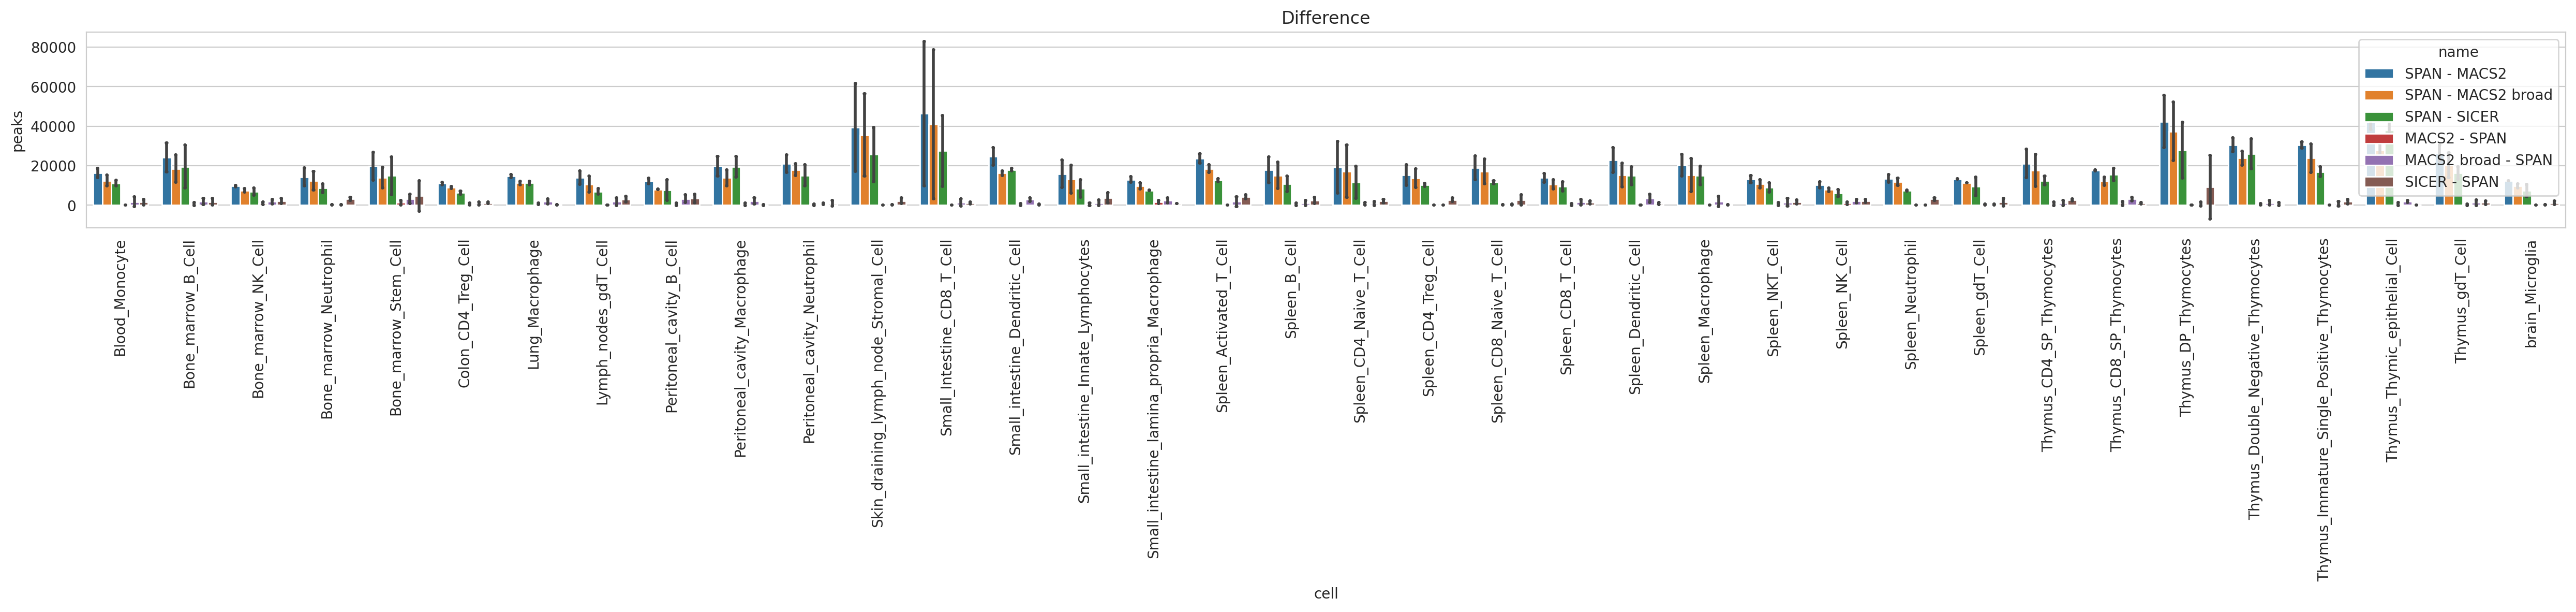

In [108]:
print('Diff')

plt.figure(figsize=(25, 6))
sns.barplot(data=diff_bench_df,
            x='cell', y='peaks', hue='name',
            hue_order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN',
                       'SICER - SPAN'],
            errorbar='sd', capsize=.05, err_kws={'linewidth': 2},
            )
plt.xticks(rotation=90)
plt.title('Difference')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Overlap with DHS

In [109]:
from itertools import product

DHS_PATH = f'{PATH}/ENCFF754WCT_mm10_dhs_representative_sites.bed'
dhs_path_sorted = sorted_file(DHS_PATH)
DHS_PEAKS = lines(DHS_PATH)


def compute_dhs_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'way', 'peaks', 'overlap'], dtype=object)
    for (srr, name, tool), dft in tqdm(list(df.groupby(['srr', 'name', 'tool']))):
        print('Processing', srr, name, tool, len(dft))
        for _, row in dft.iterrows():
            file, peaks = sorted_file(row['file']), row['peaks']

            tf = f'{PATH}/overlaps/overlaps_{tool}_{name}_{tool}_vs_dhs.bed'.replace(' ', '_')
            !bedtools intersect -a {file} -b {dhs_path_sorted} -wa -u > {tf}
            owd = lines(tf)
            dfoverlap.loc[len(dfoverlap)] = (srr, name, tool, file, 'with_dhs', peaks, owd)

            tf = f'{PATH}/overlaps/overlaps_{tool}_{name}_{tool}_dhs_vs.bed'.replace(' ', '_')
            !bedtools intersect -b {file} -a {dhs_path_sorted} -wa -u > {tf}
            odw = lines(tf)
            dfoverlap.loc[len(dfoverlap)] = (srr, name, tool, file, 'dhs_with', DHS_PEAKS, odw)
    return dfoverlap

In [118]:
dhs_overlap = compute_dhs_overlaps(dfa)
dhs_overlap.sample(3)

  0%|          | 0/740 [00:00<?, ?it/s]

Processing SRR5799381 Thymus_Thymic_epithelial_Cell MACS2 1
Processing SRR5799381 Thymus_Thymic_epithelial_Cell MACS2 broad 1
Processing SRR5799381 Thymus_Thymic_epithelial_Cell SICER 1
Processing SRR5799381 Thymus_Thymic_epithelial_Cell SPAN 1
Processing SRR5799382 Thymus_Thymic_epithelial_Cell MACS2 1
Processing SRR5799382 Thymus_Thymic_epithelial_Cell MACS2 broad 1
Processing SRR5799382 Thymus_Thymic_epithelial_Cell SICER 1
Processing SRR5799382 Thymus_Thymic_epithelial_Cell SPAN 1
Processing SRR5799383 Thymus_Double_Negative_Thymocytes MACS2 1
Processing SRR5799383 Thymus_Double_Negative_Thymocytes MACS2 broad 1
Processing SRR5799383 Thymus_Double_Negative_Thymocytes SICER 1
Processing SRR5799383 Thymus_Double_Negative_Thymocytes SPAN 1
Processing SRR5799384 Thymus_Double_Negative_Thymocytes MACS2 1
Processing SRR5799384 Thymus_Double_Negative_Thymocytes MACS2 broad 1
Processing SRR5799384 Thymus_Double_Negative_Thymocytes SICER 1
Processing SRR5799384 Thymus_Double_Negative_Thymoc

srr                            name         tool  \
130   SRR5799397        Thymus_CD8_SP_Thymocytes  MACS2 broad   
1169  SRR5799527  Small_intestine_Dendritic_Cell        MACS2   
903   SRR5799493                  Blood_Monocyte         SPAN   

                  file       way    peaks  overlap  
130   /tmp/tmp4r10oult  with_dhs    39457    36247  
1169  /tmp/tmp2wd3hbxi  dhs_with  1192301    40501  
903   /tmp/tmpfkatf5zg  dhs_with  1192301    83004

In [119]:
dhs_overlap['overlap_share'] = [o / p if p > 0 else 0 for o, p in zip(dhs_overlap['overlap'], dhs_overlap['peaks'])]
dhs_overlap.sample(3)

srr                 name   tool              file       way  \
190   SRR5799404  Colon_CD4_Treg_Cell   SPAN  /tmp/tmpby9h2_x3  with_dhs   
893   SRR5799492       Blood_Monocyte  SICER  /tmp/tmp6938epvt  dhs_with   
1072  SRR5799515        Spleen_B_Cell  MACS2  /tmp/tmpcoe7hlet  with_dhs   

        peaks  overlap  overlap_share  
190     33903    32325       0.953455  
893   1192301    81172       0.068080  
1072    25847    25095       0.970906

/tmp/ipykernel_3604901/1921127732.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t['overlap'].clip(upper=0.15, inplace=True)
/tmp/ipykernel_3604901/1921127732.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  t['overlap'].clip(upper=0.15, inplace=True)


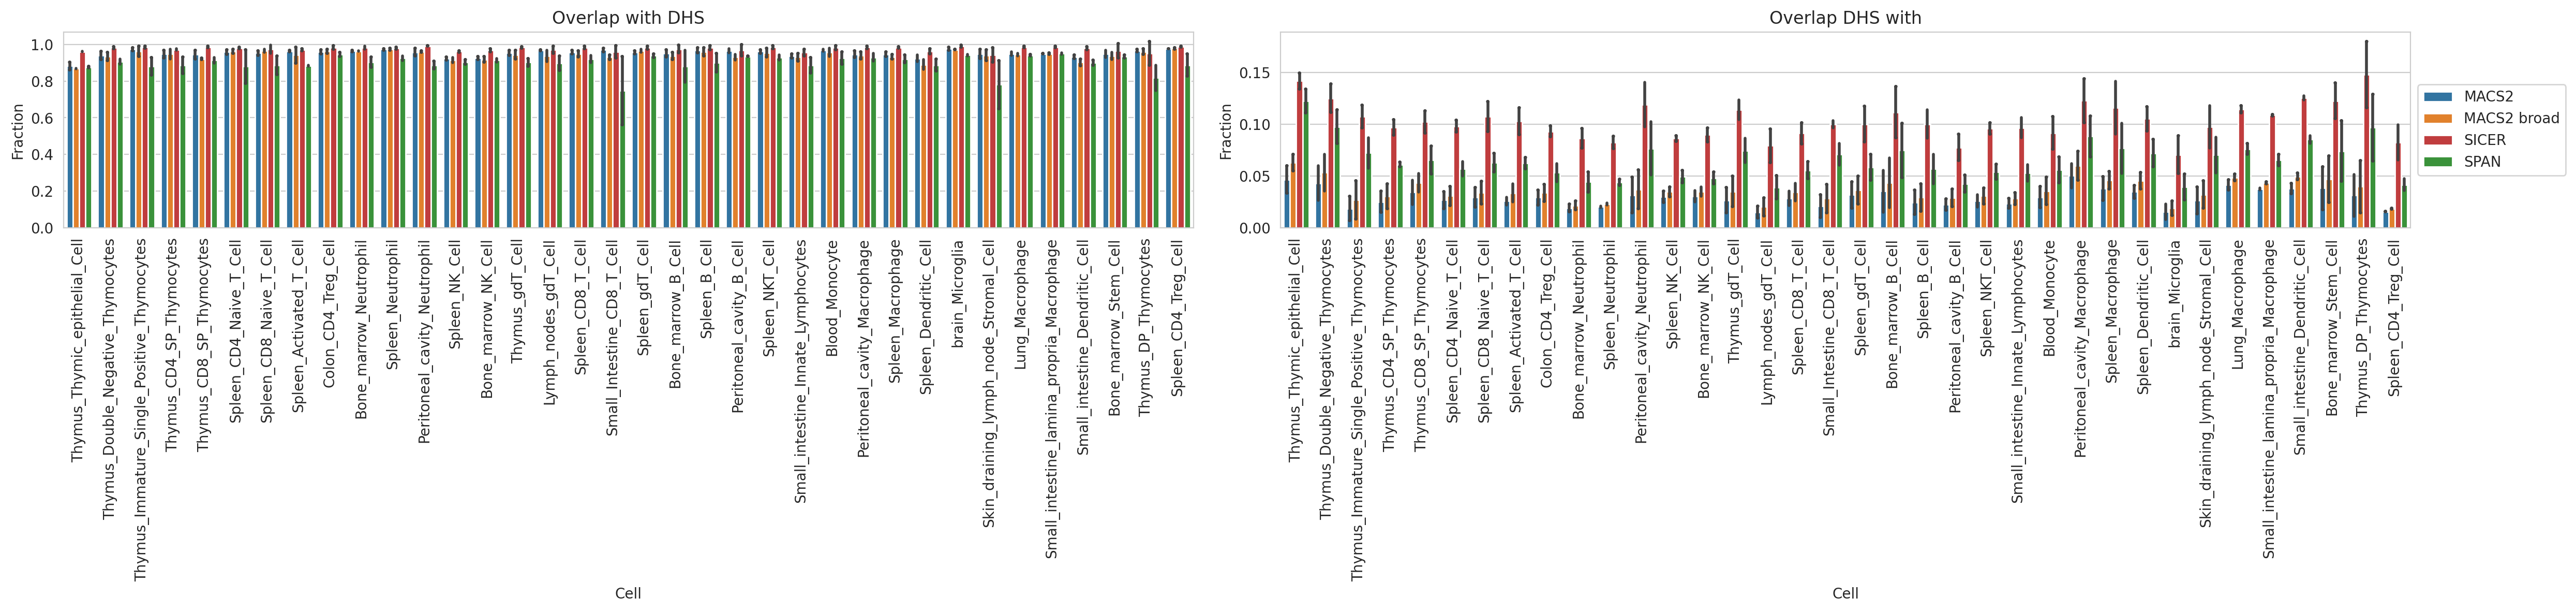

In [120]:
plt.figure(figsize=(25, 6))
# Plot 
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Overlap with DHS')
sns.barplot(data=dhs_overlap[dhs_overlap['way'] == 'with_dhs'], x='name', y='overlap_share', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05, err_kws={'linewidth': 2}, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend().set_visible(False)

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Overlap DHS with')
t = dhs_overlap[dhs_overlap['way'] == 'dhs_with'].copy()
t['overlap'].clip(upper=0.15, inplace=True)
sns.barplot(data=t, x='name', y='overlap_share', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05, err_kws={'linewidth': 2}, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{PATH}/pics/dhs.pdf', bbox_inches='tight', dpi=300)
plt.show()

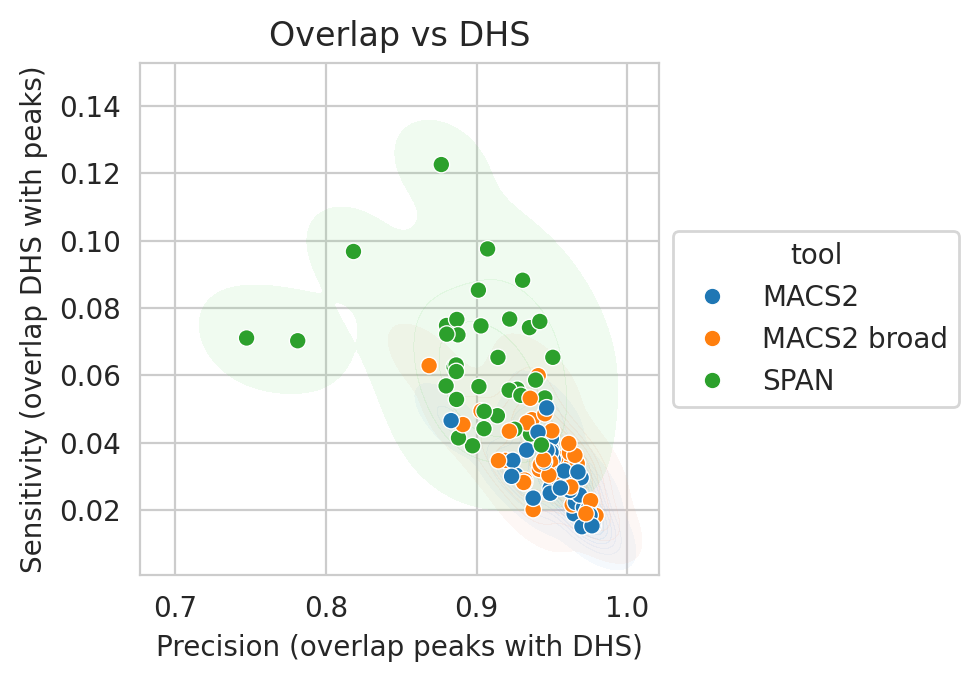

In [212]:
t = pd.pivot_table(dhs_overlap[['name', 'tool', 'way', 'overlap_share']],
                   values='overlap_share', columns=['way'], index=['name', 'tool']).reset_index()

t = t[t['tool'] != 'SICER']
plt.figure(figsize=(5, 3.5))
ax = plt.axes()
sns.kdeplot(t,
            hue='tool',
            # hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
            palette=TOOLS_PALETTE,
            x='with_dhs', y='dhs_with',
            alpha=0.1,
            thresh=0.01,
            fill=True,
            legend=False,
            ax=ax)
sns.scatterplot(
    t, x='with_dhs', y='dhs_with',
    hue='tool',
    # hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
    hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
    palette=TOOLS_PALETTE,
    ax=ax)
ax.set_xlabel('Precision (overlap peaks with DHS)')
ax.set_ylabel('Sensitivity (overlap DHS with peaks)')
ax.title.set_text('Overlap vs DHS')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Top peaks vs DHS

In [170]:
def compute_dhs_overlaps_n(df):
    dhs_file = pr.read_bed(dhs_path_sorted)
    dhs_len = dhs_file.lengths().sum()
    rows = []
    for _, (srr, n, tool, file) in tqdm(list(df[['srr', 'name', 'tool', 'file']].iterrows())):
        print('Processing', n, tool, file)
        peaks_file = pr.read_bed(sorted_file(file), as_df=True)
        if len(peaks_file) == 0:
            for top in np.linspace(1000, 50000, 25):
                rows.append((srr, n, tool, int(top), DHS_PEAKS, file, 0, 0, 0, dhs_len, 0, 0))
            continue
        peaks_file.sort_values(
            by=peaks_file.columns[8] if len(peaks_file.columns) >= 9 else peaks_file.columns[3],
            ascending=False, inplace=True
        )
        for top in np.linspace(1000, 50000, 25):
            t = PyRanges(peaks_file.head(int(top)).sort_values(by=['Chromosome', 'Start']))
            peaks = len(t)
            peaks_len = t.lengths().sum()
            ovlp = t.overlap(dhs_file)
            peaks_overlap = len(ovlp)
            overlap_len = ovlp.lengths().sum()
            dhs_overlap = len(dhs_file.overlap(t))
            rows.append((srr, n, tool, int(top), DHS_PEAKS, file, peaks, peaks_overlap, dhs_overlap, dhs_len, peaks_len, overlap_len))

    df = pd.DataFrame(
        rows,
        columns=['srr', 'name', 'tool', 'top', 'dhs_peaks', 'peaks_file', 'peaks', 'peaks_overlap', 'dhs_overlap',
                 'dhs_len', 'peaks_len', 'overlap_len'],
        dtype=object
    )
    df['jaccard'] = [
        d(o, lp + ld -o)
        for lp, ld, o in zip(df['peaks_len'], df['dhs_len'], df['overlap_len'])
    ]

    return df

In [186]:
dhs_ovlp_df = compute_dhs_overlaps_n(dfa)
dhs_ovlp_df.sample(3)

  0%|          | 0/740 [00:00<?, ?it/s]

Processing Blood_Monocyte SICER /home/jetbrains/data/2024_Immgen/sicer/SRR5799494_Blood_Monocyte_ATAC_seq-W200-G600-E100.scoreisland
Processing Blood_Monocyte SICER /home/jetbrains/data/2024_Immgen/sicer/SRR5799493_Blood_Monocyte_ATAC_seq-W200-G600-E100.scoreisland
Processing Blood_Monocyte MACS2 broad /home/jetbrains/data/2024_Immgen/macs2/SRR5799491_Blood_Monocyte_ATAC_seq_broad0.1_peaks.broadPeak
Processing Blood_Monocyte SPAN /home/jetbrains/data/2024_Immgen/span/SRR5799542_Blood_Monocyte_ATAC_seq_100_0.05.peak
Processing Blood_Monocyte MACS2 broad /home/jetbrains/data/2024_Immgen/macs2/SRR5799542_Blood_Monocyte_ATAC_seq_broad0.1_peaks.broadPeak
Processing Blood_Monocyte MACS2 /home/jetbrains/data/2024_Immgen/macs2/SRR5799493_Blood_Monocyte_ATAC_seq_q0.05_peaks.narrowPeak
Processing Blood_Monocyte SPAN /home/jetbrains/data/2024_Immgen/span/SRR5799492_Blood_Monocyte_ATAC_seq_100_0.05.peak
Processing Blood_Monocyte MACS2 /home/jetbrains/data/2024_Immgen/macs2/SRR5799492_Blood_Monocyt

srr                                        name         tool  \
17396  SRR5799392  Thymus_Immature_Single_Positive_Thymocytes  MACS2 broad   
4370   SRR5799517                    Peritoneal_cavity_B_Cell  MACS2 broad   
356    SRR5799491                              Blood_Monocyte        MACS2   

         top dhs_peaks                                         peaks_file  \
17396  43875   1192301  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   
4370   41833   1192301  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   
356    13250   1192301  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   

       peaks peaks_overlap dhs_overlap    dhs_len peaks_len overlap_len  \
17396  43529         41003       47714  311395372   9608311     9317765   
4370   40008         36845       41843  311395372   8227720     7865930   
356    13250         13157       14607  311395372   3779684     3758903   

        jaccard  
17396  0.029895  
4370   0.025231  
356    0.012070

In [187]:
dhs_ovlp_df['p'] = (dhs_ovlp_df['peaks_overlap'] + dhs_ovlp_df['dhs_overlap']) / 2
dhs_ovlp_df['precision'] = [d(x, y) for x, y in zip(dhs_ovlp_df['peaks_overlap'], dhs_ovlp_df['peaks'])]
dhs_ovlp_df['sensitivity'] = [d(x, y) for x, y in zip(dhs_ovlp_df['dhs_overlap'], dhs_ovlp_df['dhs_peaks'])]
dhs_ovlp_df['f1'] = [
    2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
    for s, p in zip(dhs_ovlp_df['sensitivity'], dhs_ovlp_df['precision'])]

SRR5799381 Thymus_Thymic_epithelial_Cell MACS2
SRR5799381 Thymus_Thymic_epithelial_Cell MACS2 broad
SRR5799381 Thymus_Thymic_epithelial_Cell SICER
SRR5799381 Thymus_Thymic_epithelial_Cell SPAN
SRR5799382 Thymus_Thymic_epithelial_Cell MACS2
SRR5799382 Thymus_Thymic_epithelial_Cell MACS2 broad
SRR5799382 Thymus_Thymic_epithelial_Cell SICER
SRR5799382 Thymus_Thymic_epithelial_Cell SPAN
SRR5799383 Thymus_Double_Negative_Thymocytes MACS2
SRR5799383 Thymus_Double_Negative_Thymocytes MACS2 broad
SRR5799383 Thymus_Double_Negative_Thymocytes SICER
SRR5799383 Thymus_Double_Negative_Thymocytes SPAN
SRR5799384 Thymus_Double_Negative_Thymocytes MACS2
SRR5799384 Thymus_Double_Negative_Thymocytes MACS2 broad
SRR5799384 Thymus_Double_Negative_Thymocytes SICER
SRR5799384 Thymus_Double_Negative_Thymocytes SPAN
SRR5799385 Thymus_Double_Negative_Thymocytes MACS2
SRR5799385 Thymus_Double_Negative_Thymocytes MACS2 broad
SRR5799385 Thymus_Double_Negative_Thymocytes SICER
SRR5799385 Thymus_Double_Negative_Thy

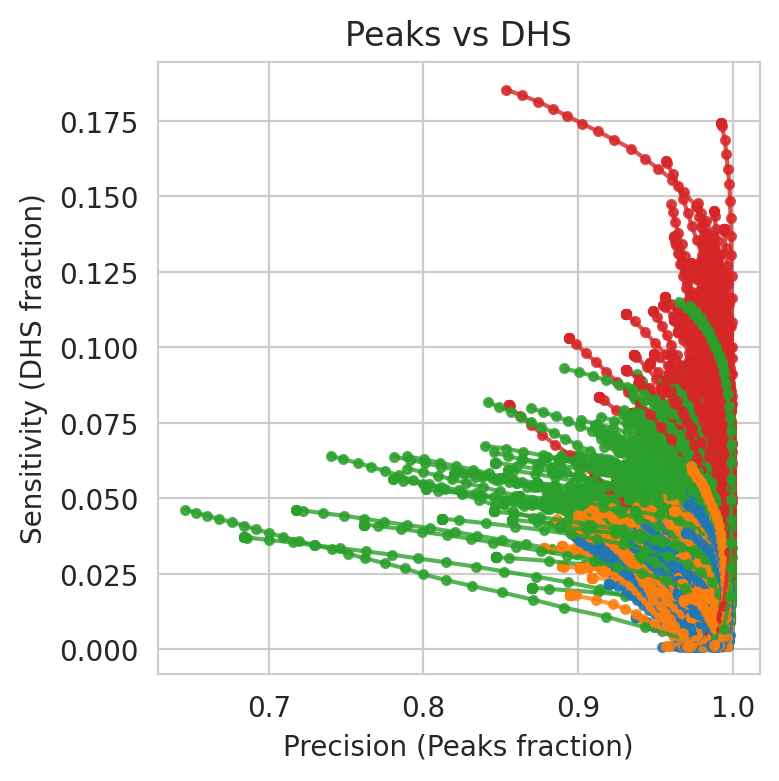

In [188]:
plt.figure(figsize=(4, 4))
for (srr, n, tool), dft in dhs_ovlp_df.groupby(['srr', 'name', 'tool']):
    print(srr, n, tool)
    plt.plot(dft['precision'], dft['sensitivity'], marker='.',
             color=TOOLS_PALETTE[tool], alpha=0.8)
plt.title('Peaks vs DHS')
plt.xlabel('Precision (Peaks fraction)')
plt.ylabel('Sensitivity (DHS fraction)')
plt.tight_layout()
plt.show()

ENCODE + Roadmap


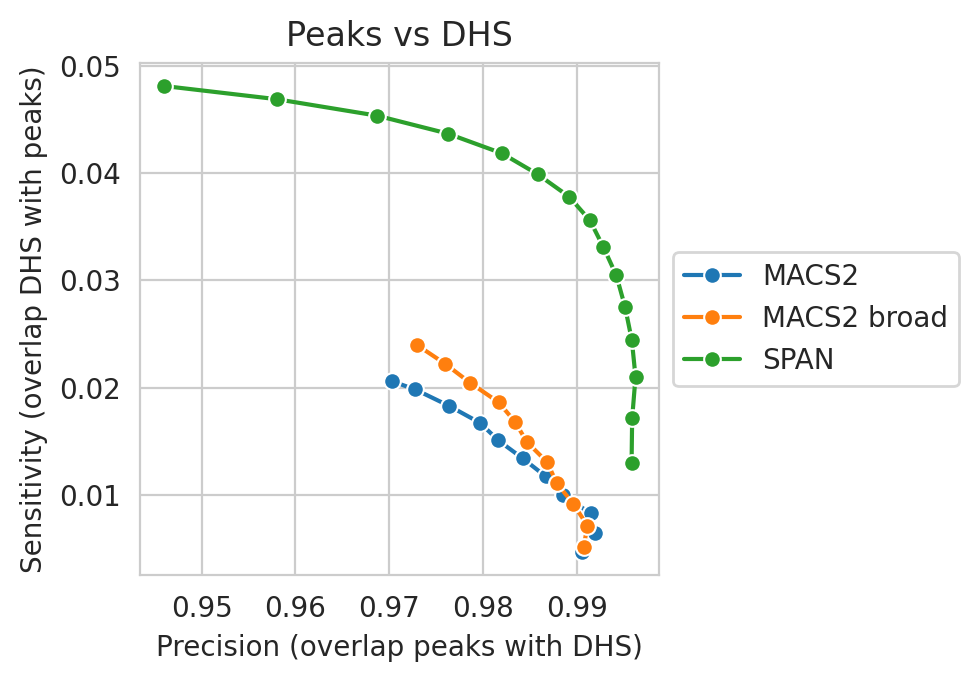

In [205]:
print('ENCODE + Roadmap')
plt.figure(figsize=(5, 3.5))
ax = plt.axes()
sns.lineplot(
    data=dhs_ovlp_df[(dhs_ovlp_df['srr'] == 'SRR5799505') & (dhs_ovlp_df['top'] >= 5000)],
    x='precision', y='sensitivity',
    hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
    hue='tool', marker='o',
    sort=False,
    palette=TOOLS_PALETTE,
    ax=ax
)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Peaks vs DHS')
plt.xlabel('Precision (overlap peaks with DHS)')
plt.ylabel('Sensitivity (overlap DHS with peaks)')

plt.tight_layout()
plt.show()

In [192]:
rows = []
for (srr, n, tool), dft in dhs_ovlp_df.groupby(['srr', 'name', 'tool']):
    dft.sort_values(by=['top'], inplace=True)
    ap = 0
    sprev, pprev = None, None
    for _, row in dft[dft['top'] > 8000].iterrows():
        if sprev is not None and pprev is not None:
            ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((srr, n, tool, ap))
dhs_ovlp_df_df = pd.DataFrame(rows, columns=['srr', 'name', 'tool', 'auc'])
del rows
dhs_ovlp_df_df.sample(2)

srr                      name  tool       auc
547  SRR5799517  Peritoneal_cavity_B_Cell  SPAN  0.029174
307  SRR5799457             Spleen_B_Cell  SPAN  0.024627

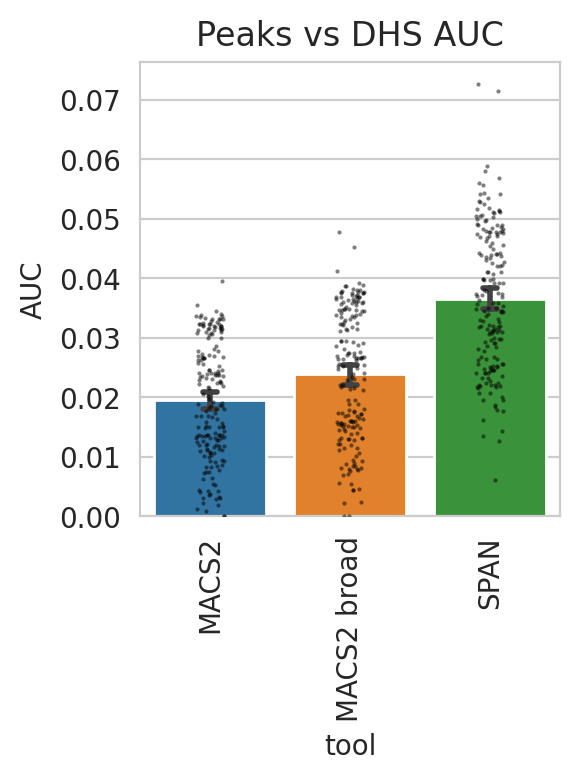

In [208]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs DHS AUC')
t = dhs_ovlp_df_df
g_results = sns.barplot(data=t, x='tool', y='auc',
                        capsize=.1, err_kws={'linewidth': 2},
                        hue='tool', legend=False,
                        order=['MACS2', 'MACS2 broad', 'SPAN'],
                        palette=TOOLS_PALETTE,
                        ax=ax)
sns.stripplot(data=t, x='tool', y='auc',
              dodge=True, size=1.5, color="black", alpha=0.5,
              # order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
              order=['MACS2', 'MACS2 broad', 'SPAN'],
              ax=ax)

ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

# Bigwigs based coverage

In [194]:
def atac_load_bws(path):
    df = pd.DataFrame(columns=['file', 'srr', 'name'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bw'):
            continue
        file = os.path.join(path, f)
        df.loc[len(df)] = (file, file_to_srr(f), file_to_name(f))
    return df


df_bams = atac_load_bws(PATH + '/bw')
df_bams.sample(3)

  0%|          | 0/185 [00:00<?, ?it/s]

file         srr  \
113  /home/jetbrains/data/2024_Immgen/bw/SRR5799488...  SRR5799488   
42   /home/jetbrains/data/2024_Immgen/bw/SRR5799543...  SRR5799543   
18   /home/jetbrains/data/2024_Immgen/bw/SRR5799490...  SRR5799490   

                                   name  
113  Small_intestine_Innate_Lymphocytes  
42         Peritoneal_cavity_Macrophage  
18   Small_intestine_Innate_Lymphocytes

In [195]:
import pyBigWig

CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'mm10.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

total_coverages = {}
ts = []
for _, (file, srr, name) in tqdm(list(df_bams[['file', 'srr', 'name']].iterrows())):
    try:
        with pyBigWig.open(file) as bw:
            total_coverage = sum(
                bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(srr, name)] = total_coverage
    except Exception:
        pass

total_coverages

  0%|          | 0/185 [00:00<?, ?it/s]

Total coverage 68706944.28250217
Total coverage 63545909.384791374
Total coverage 76152597.54262495
Total coverage 75180143.34051704
Total coverage 67265985.9938128
Total coverage 70976950.71421719
Total coverage 67699902.12035751
Total coverage 50040405.83816624
Total coverage 79785138.91390991
Total coverage 56215488.798733234
Total coverage 75621080.8723154
Total coverage 69820939.83396196
Total coverage 64223934.234651804
Total coverage 76262475.75324893
Total coverage 69310119.13946962
Total coverage 70073806.75087357
Total coverage 56029175.884141445
Total coverage 62309602.363991976
Total coverage 31460709.967515707
Total coverage 71759779.20138836
Total coverage 61197839.32630229
Total coverage 74032008.30245543
Total coverage 65423567.254221916
Total coverage 60717014.28111029
Total coverage 71577321.26472378
Total coverage 63254705.361252785
Total coverage 55841983.48340988
Total coverage 50452470.5484221
Total coverage 67069842.574133635
Total coverage 61904199.17429662
Tota

{('SRR5799401', 'Spleen_Activated_T_Cell'): 755776.3871075239,
 ('SRR5799541', 'Blood_Monocyte'): 699005.003232705,
 ('SRR5799407', 'Spleen_Neutrophil'): 837678.5729688744,
 ('SRR5799536', 'Peritoneal_cavity_Macrophage'): 826981.5767456874,
 ('SRR5799449', 'Bone_marrow_B_Cell'): 739925.8459319407,
 ('SRR5799465', 'Spleen_B_Cell'): 780746.457856389,
 ('SRR5799448', 'Bone_marrow_B_Cell'): 744698.9233239326,
 ('SRR5799446', 'Spleen_gdT_Cell'): 550444.4642198286,
 ('SRR5799500', 'Spleen_Macrophage'): 877636.528053009,
 ('SRR5799430', 'Lymph_nodes_gdT_Cell'): 618370.3767860655,
 ('SRR5799515', 'Spleen_B_Cell'): 831831.8895954695,
 ('SRR5799526', 'Small_intestine_Dendritic_Cell'): 768030.3381735815,
 ('SRR5799478', 'Spleen_NKT_Cell'): 706463.2765811698,
 ('SRR5799405', 'Bone_marrow_Neutrophil'): 838887.2332857382,
 ('SRR5799492', 'Blood_Monocyte'): 762411.3105341658,
 ('SRR5799509', 'Skin_draining_lymph_node_Stromal_Cell'): 770811.8742596091,
 ('SRR5799520', 'Lung_Macrophage'): 616320.934725

In [196]:
total_coverages_df = pd.DataFrame([(srr, name, reads) for (srr, name), reads in total_coverages.items()],
                                  columns=['srr', 'name', 'reads'])
total_coverages_df.sample(5)

srr                                name          reads
102  SRR5799485  Small_intestine_Innate_Lymphocytes  679364.835573
45   SRR5799502               Spleen_Dendritic_Cell  743584.174589
10   SRR5799515                       Spleen_B_Cell  831831.889595
121  SRR5799513                       Spleen_B_Cell  834933.953714
132  SRR5799477                     Spleen_NKT_Cell  689490.167379

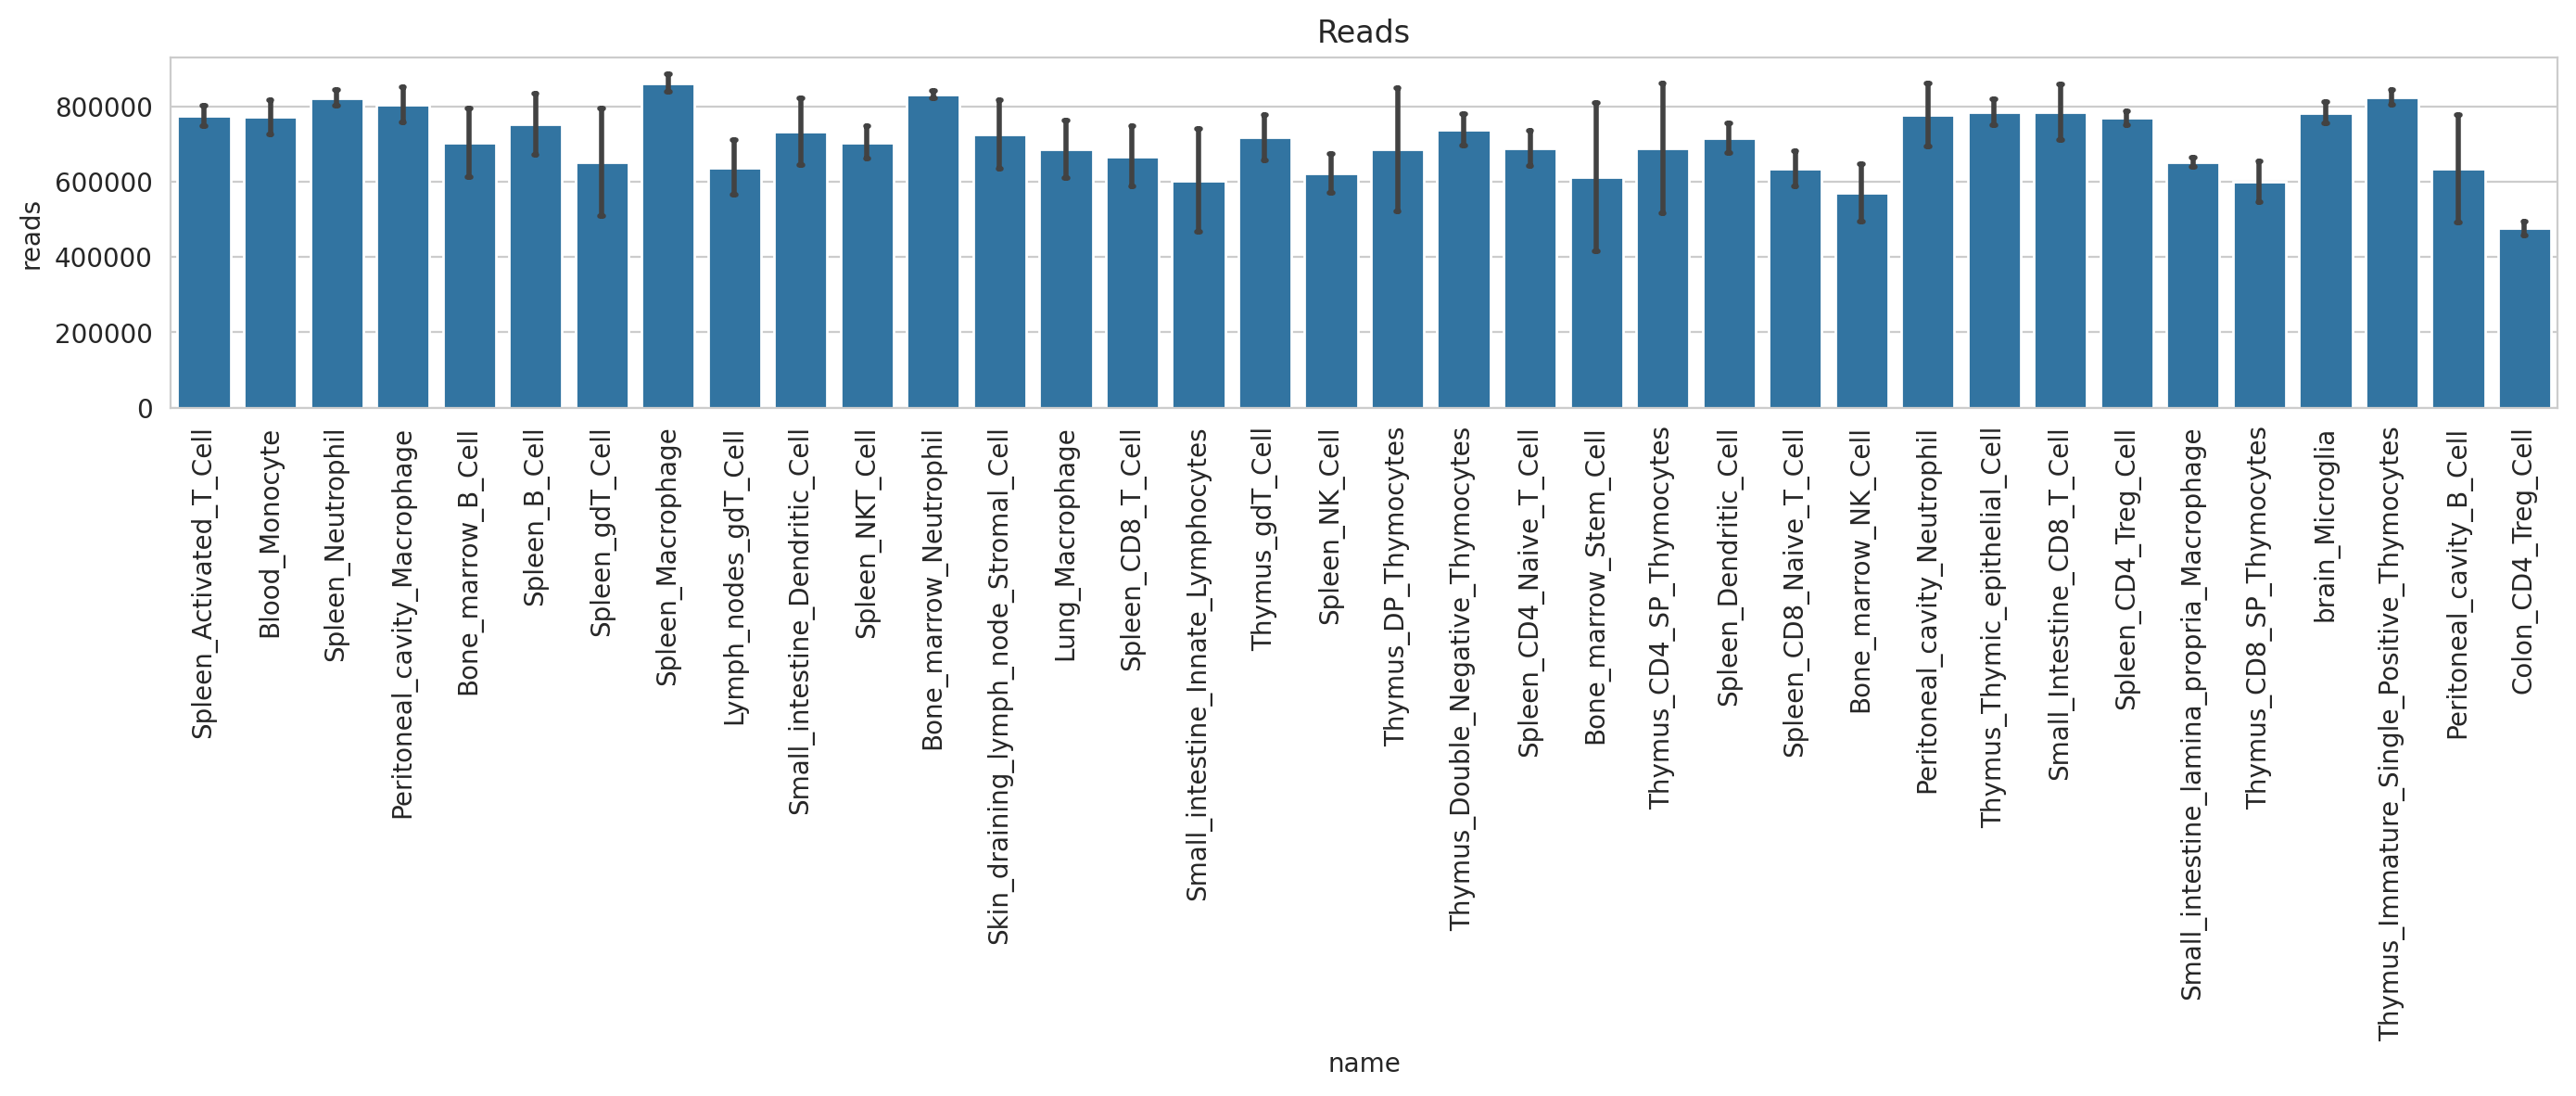

In [197]:
plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=total_coverages_df, x='name', y='reads',
                       errorbar='sd', capsize=.05, err_kws={'linewidth': 2})
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Reads')
plt.tight_layout()
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference coverage

In [198]:
tf = tempfile.mktemp()

rows = []
for srr in tqdm(dfa['srr'].unique()):
    # if srr != 'SRR5799505':
    #     continue
    print(srr)
    t = dfa[(dfa['tool'] == 'SPAN') & (dfa['srr'] == srr)]
    if len(t) != 1:
        continue
    span_file = sorted_file(t['file'].values[0])
    cell_name = t['name'].values[0]
    totalm = total_coverages[(srr, cell_name)] * 1e-6
    # Processing single tools information
    bw_path = df_bams[(df_bams['srr'] == srr) & (df_bams['name'] == cell_name)]['file'].values[0]
    with pyBigWig.open(bw_path) as bw:
        for tool in dfa['tool'].unique():
            if tool == 'SPAN':
                continue
            t = dfa[(dfa['tool'] == tool) & (dfa['srr'] == srr)]
            if len(t) != 1:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !echo '' > {tf}
                !bedtools intersect {args} -wa -v > {tf}
                t2 = pd.read_csv(tf, sep='\t', header=None)
                # if len(t.columns) < 9:
                #     display(t.head())
                #     return 
                t2.sort_values(by=[8] if len(t2.columns) >= 9 else [3], ascending=False, inplace=True)
                t2 = t2[~t2[0].str.contains('M|_', regex=True)]
                for _, (chr, start, end) in t2.head(50)[[0, 1, 2]].iterrows():
                    cov = bw.stats(chr, start, end, exact=True, type='sum')[0]
                    rpk = cov / (end - start) * 1e3
                    rpm = cov / totalm
                    rpkm = rpk / totalm
                    rows.append((srr, cell_name, name, len(t2), chr, start, end, end - start, rpk, rpm, rpkm))

diff_bench_coverage_df = pd.DataFrame(
    rows,
    columns=['srr', 'cell', 'name', 'peaks', 'chromosome', 'start', 'end', 'length', 'rpk', 'rpm', 'rpkm'],
    dtype=object
)
diff_bench_coverage_df.sample(3)

  0%|          | 0/185 [00:00<?, ?it/s]

SRR5799494
SRR5799493
SRR5799491
SRR5799542
SRR5799492
SRR5799541
SRR5799447
SRR5799454
SRR5799533
SRR5799449
SRR5799448
SRR5799455
SRR5799471
SRR5799451
SRR5799452
SRR5799470
SRR5799453
SRR5799450
SRR5799421
SRR5799419
SRR5799420
SRR5799416
SRR5799418
SRR5799417
SRR5799405
SRR5799406
SRR5799530
SRR5799537
SRR5799528
SRR5799539
SRR5799538
SRR5799404
SRR5799403
SRR5799518
SRR5799520
SRR5799521
SRR5799519
SRR5799431
SRR5799430
SRR5799432
SRR5799433
SRR5799428
SRR5799429
SRR5799461
SRR5799517
SRR5799536
SRR5799532
SRR5799531
SRR5799498
SRR5799529
SRR5799544
SRR5799497
SRR5799496
SRR5799543
SRR5799495
SRR5799549
SRR5799548
SRR5799409
SRR5799508
SRR5799510
SRR5799552
SRR5799506
SRR5799511
SRR5799509
SRR5799507
SRR5799550
SRR5799445
SRR5799444
SRR5799526
SRR5799527
SRR5799525
SRR5799524
SRR5799483
SRR5799487
SRR5799486
SRR5799488
SRR5799484
SRR5799485
SRR5799489
SRR5799490
SRR5799523
SRR5799522
SRR5799402
SRR5799401
SRR5799459
SRR5799458
SRR5799474
SRR5799514
SRR5799464
SRR5799516
SRR5799463

srr                                   cell                name  \
48331  SRR5799385      Thymus_Double_Negative_Thymocytes        SPAN - SICER   
17685  SRR5799552  Skin_draining_lymph_node_Stromal_Cell        MACS2 - SPAN   
26546  SRR5799460                          Spleen_B_Cell  SPAN - MACS2 broad   

       peaks chromosome     start       end length         rpk         rpm  \
48331  31483      chr17  89453205  89453885    680  181.575792  167.358158   
17685     47      chr15  55468480  55468575     95   194.86163    27.71704   
26546  15383       chr6  90988165  90989305   1140  197.167919  309.101336   

             rpkm  
48331  246.114939  
17685  291.758313  
26546  271.141523

Diff


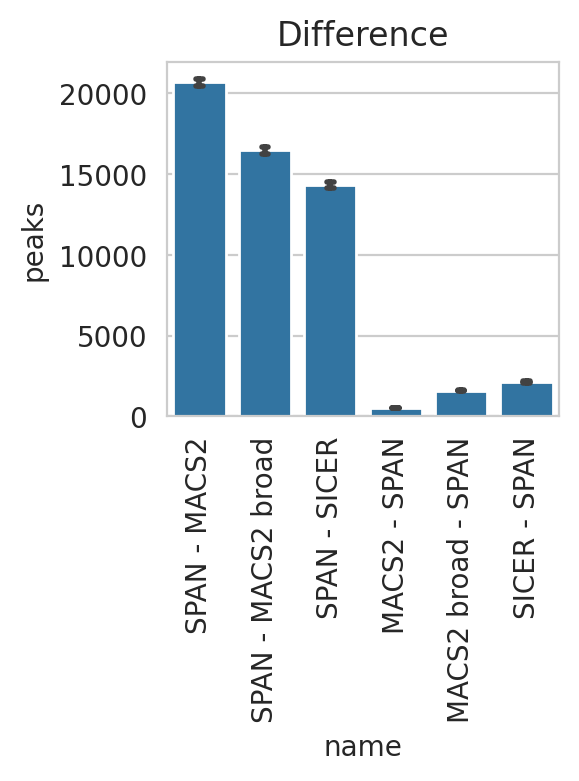

In [202]:
print('Diff')

plt.figure(figsize=(3, 4))
sns.barplot(data=diff_bench_coverage_df,
            x='name', y='peaks',
            order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
            capsize=.1, err_kws={'linewidth': 2})
plt.xticks(rotation=90)
plt.title('Difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


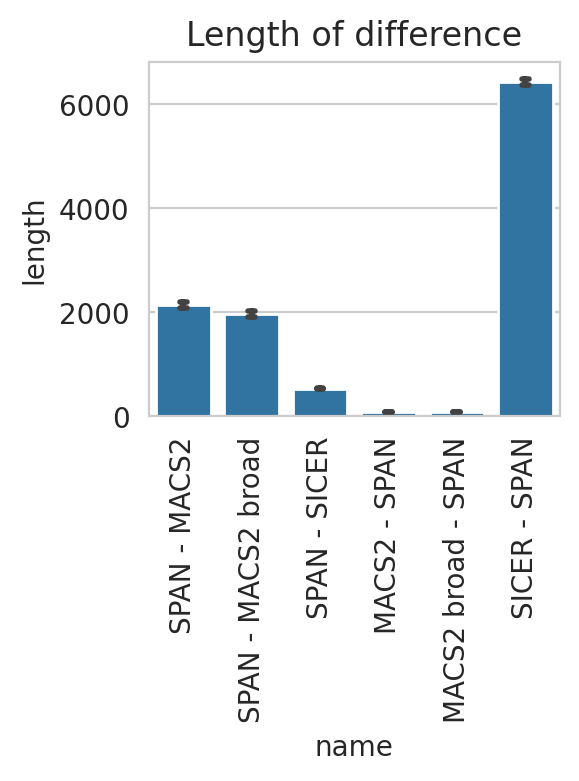

In [203]:
print('Diff')

plt.figure(figsize=(3, 4))
sns.barplot(data=diff_bench_coverage_df,
            x='name', y='length',
            order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
            capsize=.1, err_kws={'linewidth': 2},
            )
plt.xticks(rotation=90)
plt.title('Length of difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


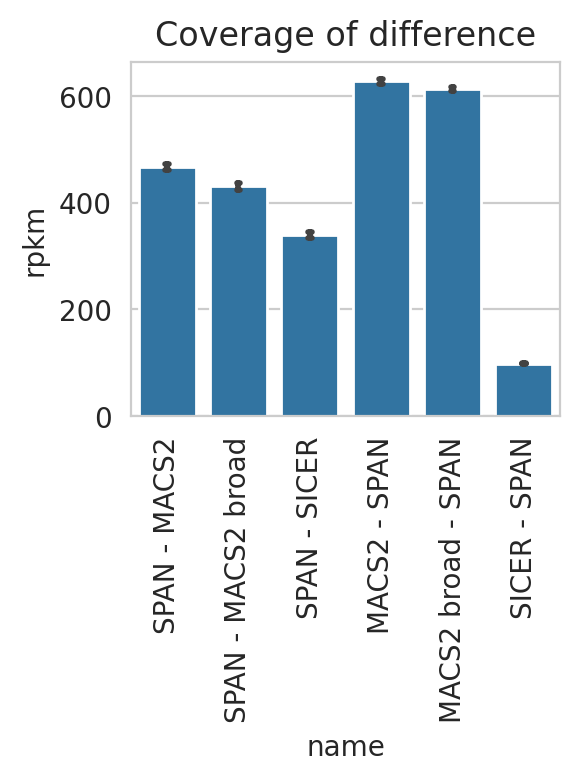

In [204]:
print('Diff')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=diff_bench_coverage_df,
                       x='name', y='rpkm',
                       order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
                       # order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
                       capsize=.05, err_kws={'linewidth': 2},
                       )
plt.xticks(rotation=90)
plt.title('Coverage of difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

# END